In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import numpy as np
import tensorflow as tf

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as base_preprocess
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time
import shutil

In [4]:
# Define the paths and constants
zip_path = '/content/drive/MyDrive/data.zip'
extract_path = '/content/'
image_folder = '/content/data/images/'
processed_folder = '/content/data/images_processed/'
target_size = 224
batch_size = 64

# Create the directory for processed folder
os.makedirs(processed_folder, exist_ok=True)

# Unzip and verify contents
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("Unzipping complete.")
print(f"Contents of {extract_path}:\n{os.listdir(extract_path)}")

Unzipping complete.
Contents of /content/:
['.config', 'drive', 'data', 'sample_data']


In [5]:
# Load the csv
df = pd.read_csv("data/GroundTruth.csv")

# Get first image ID from CSV
image_id = df.iloc[0]['image']

# Load the image
img = cv2.imread(f"data/images/{image_id}.jpg")

# Print the shape
print(f"Image shape: {img.shape}")

Image shape: (450, 600, 3)


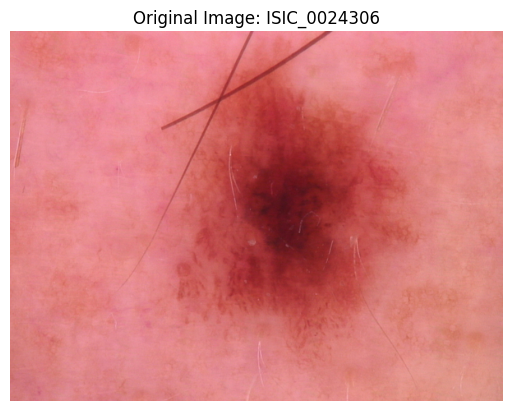

In [6]:
# Display the image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title(f"Original Image: {image_id}")
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [7]:
# Custom preprocessing function
def center_crop_and_resize(img, target_size=224):
    """
    Take the largest possible center square from the image, no distortion
    Resize that square to (224 x 224)
    """

    h, w = img.shape[:2]

    # Size of the largest possible center square
    min_side = min(h, w)

    # Starting points for center crop
    start_x = (w - min_side) // 2
    start_y = (h - min_side) // 2

    # Center crop
    img_cropped = img[start_y:start_y + min_side,
                      start_x:start_x + min_side]

    # Resize the center crop to 224 x 224
    img_resized = cv2.resize(
        img_cropped,
        (target_size, target_size),
        interpolation=cv2.INTER_AREA if min_side > target_size else cv2.INTER_CUBIC
    )

    return img_resized

In [8]:
# Map each label to numeric index through a dictionary
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}
for i in range(len(df)):
    # Columns starting from index 1 because index 0 is the image ID
    labels = df.iloc[i,1:]
    # Find which column has the value '1' to get its index and create a new 'label' column
    df.loc[i,"label"] = mapping[list(labels).index(1)]
# Reset the dataframe index for the next loop
df = df.reset_index()

for index, row in df.iterrows():
    # Full path to the original image
    original_path = os.path.join(image_folder, row['image'] + '.jpg')
    # Read the image
    img = cv2.imread(original_path)
    # If something wrong with the image, print error
    if img is None:
        print(f"Could not read image at {original_path}. Skipping.")
        continue
    # Apply cumstom function
    img_processed = center_crop_and_resize(img, target_size=target_size)
    # The path where the new processed images will be
    processed_path = os.path.join(processed_folder, row['image'] + '.jpg')
    cv2.imwrite(processed_path, img_processed)

print("Preprocessing complete. Images saved to the new directory.")
# New column: 'filepath' to point to the path of the new processed images
df['filepath'] = processed_folder + df['image'] + '.jpg'
df.set_index('image', inplace=True)
# Print the first 5 rows to verify
print(df.head())
print()
# Print all column names
print(df.columns)

Preprocessing complete. Images saved to the new directory.
              index  MEL   NV  BCC  AKIEC  BKL   DF  VASC label  \
image                                                             
ISIC_0024306      0  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV   
ISIC_0024307      1  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV   
ISIC_0024308      2  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV   
ISIC_0024309      3  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV   
ISIC_0024310      4  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL   

                                                     filepath  
image                                                          
ISIC_0024306  /content/data/images_processed/ISIC_0024306.jpg  
ISIC_0024307  /content/data/images_processed/ISIC_0024307.jpg  
ISIC_0024308  /content/data/images_processed/ISIC_0024308.jpg  
ISIC_0024309  /content/data/images_processed/ISIC_0024309.jpg  
ISIC_0024310  /content/data/images_processed/ISIC_0024310.jpg  

Index(['index', 'MEL',

Selected image: ISIC_0024306
Original shape: (450, 600, 3)
Processed shape: (224, 224, 3)


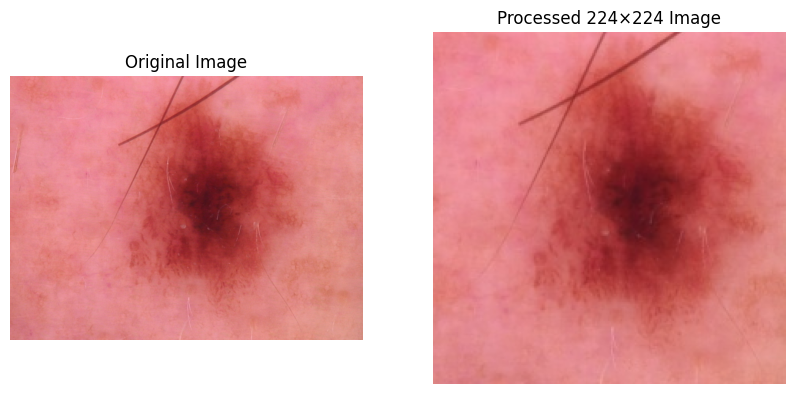

In [9]:
# Any image ID from the dataframe
sample_id = df.index[0]    # or replace with image name
print("Selected image:", sample_id)

# Original image
original_path = os.path.join(image_folder, sample_id + ".jpg")
orig = cv2.imread(original_path)
if orig is not None:
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    print("Original shape:", orig.shape)
else:
    print("Original image not found at:", original_path)

# Processed image
processed_path = df.loc[sample_id, "filepath"]
proc = cv2.imread(processed_path)
if proc is not None:
    proc_rgb = cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)
    print("Processed shape:", proc.shape)
else:
    print("Processed image not found at:", processed_path)

# Visualize both original and processed
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Processed 224×224 Image")
plt.imshow(proc_rgb)
plt.axis("off")

plt.show()


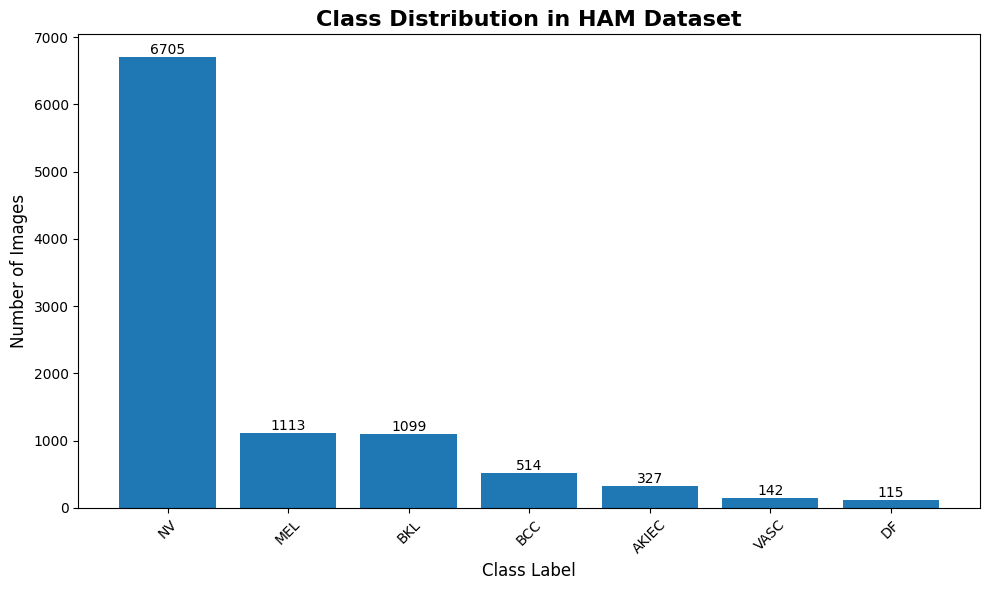

Class Distribution:
label
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64

Total images: 10015


In [10]:
# Count the occurrences of each label
class_counts = df['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution in HAM Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the counts
print("Class Distribution:")
print(class_counts)
print(f"\nTotal images: {class_counts.sum()}")

In [ ]:
# Split the full data into 95% and the final Test set 5%
# This creates the final, unbiased test set
train_val_df, test_df = train_test_split(df,
                                         test_size=0.05,  # 5% for the final test set
                                         stratify=df['label'],
                                         random_state=42)

# Split the train_val_df, which is 95% of total into Training (80% of total) and Validation (15% of total)
# Relative validation size: 0.15
val_size_relative = 0.15 / 0.95

train_df, val_df = train_test_split(train_val_df,
                                    test_size=val_size_relative,
                                    stratify=train_val_df['label'],
                                    random_state=42)

print(f"Training samples: {len(train_df)} ({len(train_df)/len(df):.2%})")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(df):.2%})")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df):.2%})")

Training samples: 8011 (79.99%)
Validation samples: 1503 (15.01%)
Test samples: 501 (5.00%)


Keeping NV: 5364
Upsampling AKIEC: 262 → 962
Upsampling VASC: 113 → 813
Upsampling BCC: 411 → 1111
Upsampling MEL: 890 → 1590
Upsampling DF: 92 → 792
Upsampling BKL: 879 → 1579

Calculated Class Weights for balanced set
{'AKIEC': np.float64(1.8133353133353134), 'BCC': np.float64(1.57014272855857), 'BKL': np.float64(1.104767936306885), 'DF': np.float64(2.2025613275613276), 'MEL': np.float64(1.0971248876909254), 'NV': np.float64(0.32521039735804835), 'VASC': np.float64(2.1456685995431384)}

New Balanced Training Distribution
label
AKIEC     962
BCC      1111
BKL      1579
DF        792
MEL      1590
NV       5364
VASC      813
Name: count, dtype: int64


/tmp/ipython-input-1115634411.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


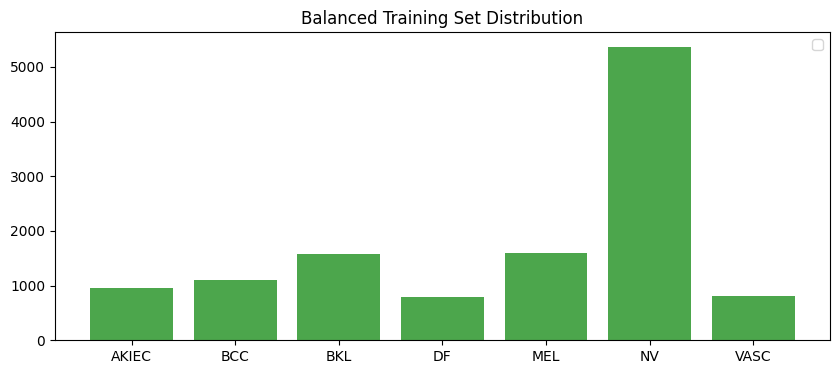

In [ ]:
# Class weights 
majority_class = "NV"
upsample = 700

# Classes from the original train_df
unique_classes = sorted(train_df["label"].unique())

balanced_dfs = []

for class_name in train_df['label'].unique():
    class_df = train_df[train_df['label'] == class_name]
    count = len(class_df)

    if class_name == majority_class:
        # Keep NV exactly as is
        print(f"Keeping {class_name}: {count}")
        balanced_dfs.append(class_df)

    else:
        # Add 700 samples
        print(f"Upsampling {class_name}: {count} → {count + upsample}")

        extra_samples = class_df.sample(
            n=upsample,
            replace=True,
            random_state=42
        )

        new_class_df = pd.concat([class_df, extra_samples])
        balanced_dfs.append(new_class_df)

# Combine and shuffle
balanced_train_df = (
    pd.concat(balanced_dfs)
      .sample(frac=1, random_state=42)
      .reset_index(drop=True)
)

# Class weights on the new balanced data
balanced_classes_np = np.array(unique_classes)
new_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=balanced_classes_np,
    y=balanced_train_df["label"] # The balanced labels
)

class_wt_dict = dict(zip(unique_classes, new_class_weights))

print("\nCalculated Class Weights for balanced set")
print(class_wt_dict)


# Visualizing new distribution
print("\nNew Balanced Training Distribution")
new_counts = balanced_train_df['label'].value_counts().sort_index()
print(new_counts)

plt.figure(figsize=(10, 4))
bars = plt.bar(new_counts.index, new_counts.values, color='green', alpha=0.7)
plt.title('Balanced Training Set Distribution')
plt.legend()
plt.show()

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess,  # Normalize pixel values to match base model logic
    rotation_range=30,       # Randomly rotate image plus-minus 30 degrees 
    width_shift_range=0.1,   # Randomly shift image horizontally up to 10% 
    height_shift_range=0.1,  # Randomly shift image vertically up to 10%
    shear_range=0.1,         # Distort image angle by 10% 
    zoom_range=0.2,          # Randomly zoom in or out by 20% 
    horizontal_flip=True,    # Randomly flip image left-to-right
    fill_mode='nearest'      # Fill empty space created by rotation with the closest pixel color
)

# Clean generator for both validation and test
val_test_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess
)

In [ ]:
class_names = sorted(df['label'].unique())

# Training iterator, 80% set for training with augmentation
train_image_gen = train_gen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col='filepath',
    y_col='label',
    classes=class_names,
    target_size=(target_size, target_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    workers=2,
    use_multiprocessing=False
)

# Validation iterator
val_image_gen = val_test_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    classes=class_names,
    target_size=(target_size, target_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42,
    workers=2,
    use_multiprocessing=False
)

# Test iterator, 5% set for unbiased evaluation
final_test_image_gen = val_test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    classes=class_names,
    target_size=(target_size, target_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=2,
    use_multiprocessing=False
)

print("\nData Generators:")
print(f"Training samples: {train_image_gen.samples}")
print(f"Validation samples: {val_image_gen.samples}")
print(f"Test samples: {final_test_image_gen.samples}")
print(f"Class indices: {val_image_gen.class_indices}")

Found 12211 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
Found 501 validated image filenames belonging to 7 classes.

Data Generators:
Training samples: 12211
Validation samples: 1503
Test samples: 501
Class indices: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


In [ ]:
# Mapping of class name, the integer Index from the generator
# Example: {'AKIEC': 0, 'BCC': 1, ...}
class_indices = train_image_gen.class_indices

# Create a new dictionary mapping integer Index to Weight
# Map the string keys from your calculated 'class_wt_dict' to the integers
keras_class_weights = {
    class_indices[name]: weight
    for name, weight in class_wt_dict.items()
}

print("\nFinal Class Weights (Formatted for Keras):")
print(keras_class_weights)


Final Class Weights (Formatted for Keras):
{0: np.float64(1.8133353133353134), 1: np.float64(1.57014272855857), 2: np.float64(1.104767936306885), 3: np.float64(2.2025613275613276), 4: np.float64(1.0971248876909254), 5: np.float64(0.32521039735804835), 6: np.float64(2.1456685995431384)}


In [ ]:
# Create the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Build the custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, kernel_regularizer=l2(0.01), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0001)
tl_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Resnet50 Model Summary:")
tl_model.summary()

# Show model architecture diagram
print("\nModel Architecture:")
print(f"Input shape: {tl_model.input_shape}")
print(f"Output shape: {tl_model.output_shape}")
print(f"Total layers: {len(tl_model.layers)}")
print(f"Trainable parameters: {tl_model.count_params()}")

Resnet50 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,146,055 (92.11 MB)

 Trainable params: 24,092,935 (91.91 MB)

 Non-trainable params: 53,120 (207.50 KB)


Model Architecture:
Input shape: (None, 224, 224, 3)
Output shape: (None, 7)
Total layers: 181
Trainable parameters: 24146055


In [ ]:
# Setup and Callbacks

# Define callbacks for better training
callbacks = [
    # Save the best model
    ModelCheckpoint(
        filepath='best_resnet50_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.000001,
        verbose=1
    )
]

# Calculate steps per epoch
steps_per_epoch = len(train_image_gen)
validation_steps = len(val_image_gen) # Calculated for the 15% validation set

print(f"\nTraining Parameters:")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Batch size: {batch_size}")
print(f"Total epochs to run: 20")
print(f"Using class weights: {keras_class_weights}")
print(f"Model input shape: {tl_model.input_shape}")
print(f"Model output shape: {tl_model.output_shape}")


Training Parameters:
Steps per epoch: 191
Validation steps: 24
Batch size: 64
Total epochs to run: 20
Using class weights: {0: np.float64(1.8133353133353134), 1: np.float64(1.57014272855857), 2: np.float64(1.104767936306885), 3: np.float64(2.2025613275613276), 4: np.float64(1.0971248876909254), 5: np.float64(0.32521039735804835), 6: np.float64(2.1456685995431384)}
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 7)


In [20]:
# Start training
start_time = time.time()

history = tl_model.fit(
    train_image_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_image_gen, # Using 15% Validation set
    validation_steps=validation_steps,
    class_weight=keras_class_weights,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")
print(f"Total epochs trained: {len(history.history['loss'])}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3642 - loss: 3.4441
Epoch 1: val_accuracy improved from -inf to 0.71989, saving model to best_resnet50_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.3649 - loss: 3.4416 - val_accuracy: 0.7199 - val_loss: 2.3619 - learning_rate: 1.0000e-04
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.6951 - loss: 2.2406
Epoch 2: val_accuracy improved from 0.71989 to 0.78110, saving model to best_resnet50_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6952 - loss: 2.2400 - val_accuracy: 0.7811 - val_loss: 1.9286 - learning_rate: 1.0000e-04
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7795 - loss: 1.7913
Epoch 3: val_accuracy did not improve from 0.78110
191/191 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7795 - loss: 1.7910 - val_accuracy: 0.6593 - val_loss: 2.1487 - learning_rate: 1.0000e-04
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accurac

In [21]:
print("Final Model Evaluation on Unseen Test Set (5%)")

# Calculate test steps
test_steps = len(final_test_image_gen)

# Evaluate on validation set
test_loss, test_accuracy = tl_model.evaluate(
    final_test_image_gen,
    steps=test_steps,
    verbose=1
)

print(f"\nTest Set Results (5% of data):")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")

# Save the final model
tl_model.save('final_resnet50_model.keras')
print("\nModel saved as 'final_resnet50_model.keras'")

Final Model Evaluation on Unseen Test Set (5%)
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8540 - loss: 0.8106

Test Set Results (5% of data):
Loss: 0.8102
Accuracy: 0.8523 (85.23%)


Model saved as 'final_resnet50_model.keras'


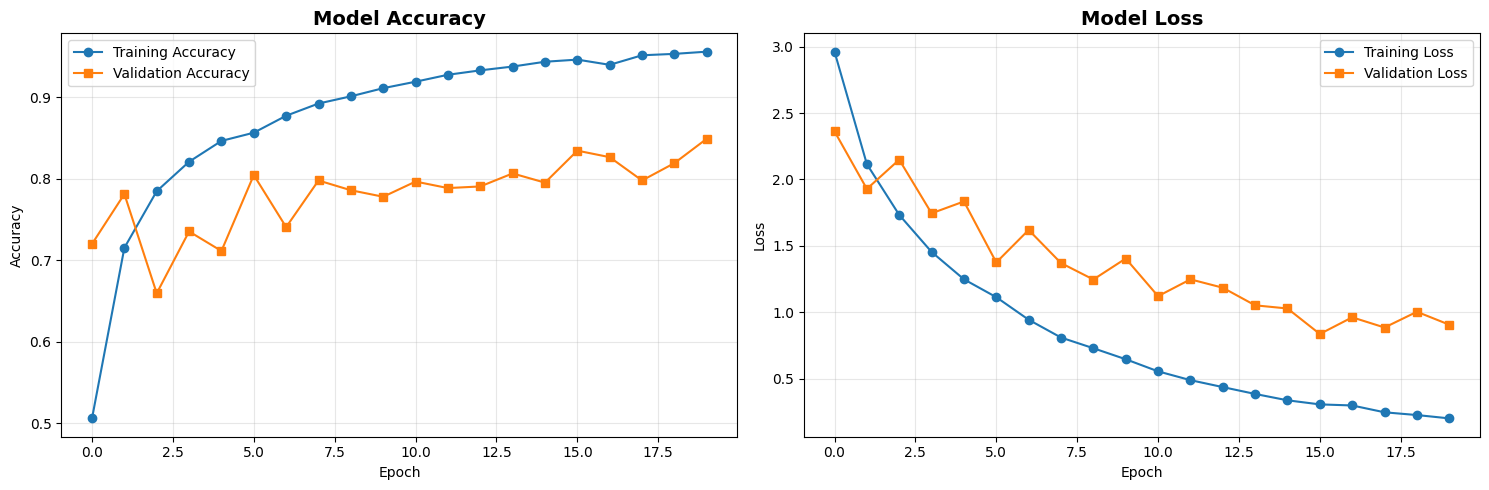

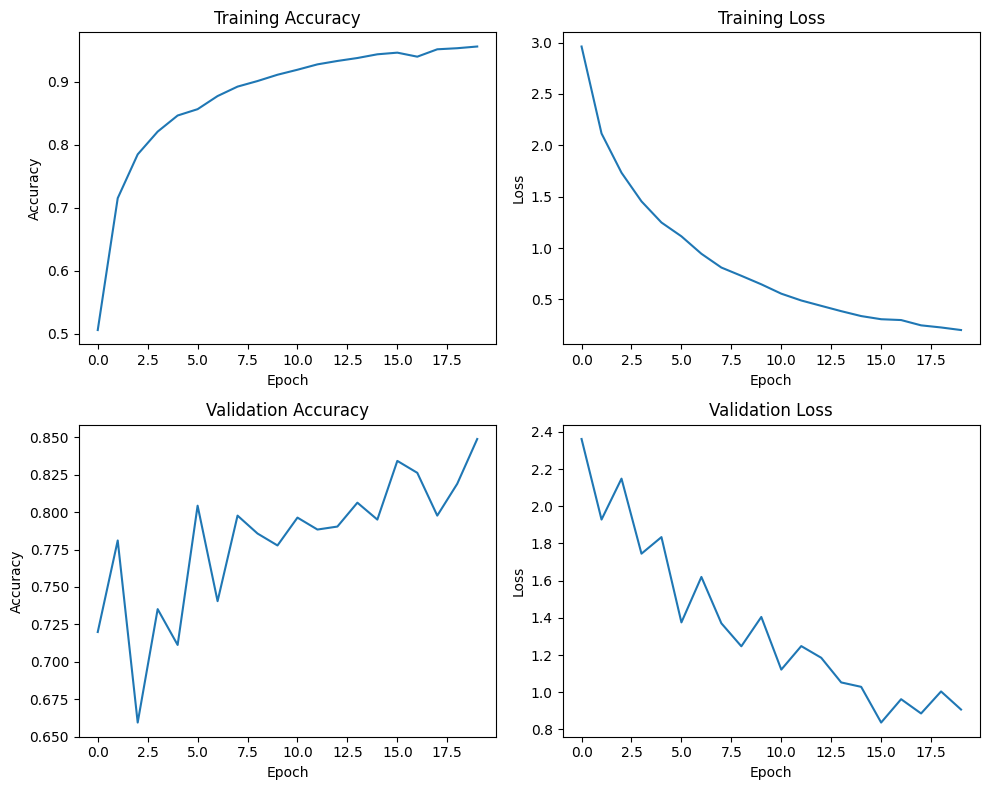

In [22]:
# Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional detailed plot
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 4)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [23]:
# Predictions
final_test_image_gen.reset()
y_pred = []
y_true = []
y_pred_proba = []

print("Predictions on the 5% Test Set")
test_steps = len(final_test_image_gen)

for i in range(test_steps):
    batch_x, batch_y = next(final_test_image_gen)
    preds = tl_model.predict(batch_x, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred_proba.extend(preds)

print(f"Total predictions: {len(y_pred)}")

Predictions on the 5% Test Set
Total predictions: 501


In [24]:
# Setup directory
output_dir = 'test_predictions'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get Information from Generator
filepaths = final_test_image_gen.filepaths
true_classes = final_test_image_gen.classes
class_names = list(final_test_image_gen.class_indices.keys())

# Loop through every test image
for i in range(len(filepaths)):

    # Load original image
    original_img = cv2.imread(filepaths[i])

    # Apply custom crop/resize function preprocessing
    img_display = center_crop_and_resize(original_img, target_size=224)

    # Convert to RGB for matplotlib display
    img_display_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    # Prepare for prediction
    img_batch = np.expand_dims(img_display_rgb, axis=0)
    img_preprocessed = base_preprocess(img_batch.copy())

    # Prediction on the single image
    sample_pred = tl_model.predict(img_preprocessed, verbose=0)[0]
    sample_pred_class_idx = np.argmax(sample_pred)
    sample_pred_class = class_names[sample_pred_class_idx]
    sample_confidence = sample_pred[sample_pred_class_idx]

    # Get true class label
    true_label_idx = true_classes[i]
    sample_true_class = class_names[true_label_idx]

    # Display the image with prediction
    plt.figure(figsize=(5, 5))

    # Display image
    plt.imshow(img_display_rgb)

    # Set Title with True vs Pred
    plt.title(f'True: {sample_true_class}\nPred: {sample_pred_class} ({sample_confidence:.2%})')
    plt.axis('off')

    # Save predicted image
    filename = os.path.basename(filepaths[i])
    save_path = os.path.join(output_dir, filename)

    plt.savefig(save_path, bbox_inches='tight')

    # Close to free memory
    plt.close()

print(f"All {len(filepaths)} images saved to {output_dir}")

All 501 images saved to test_predictions


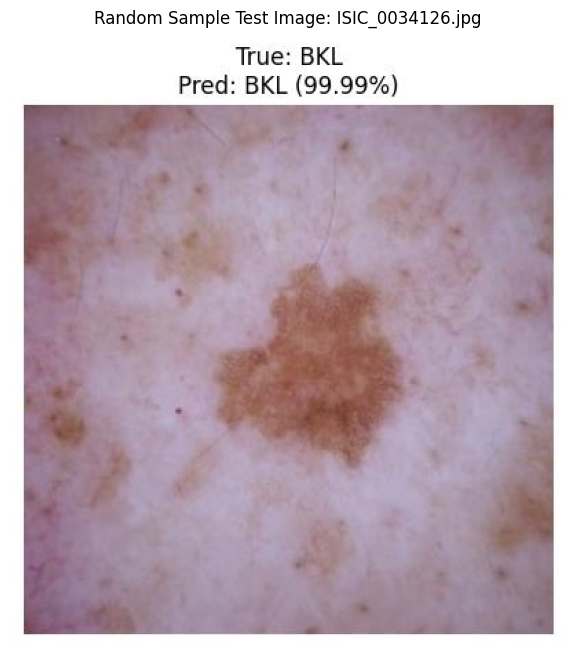

In [ ]:
# Define the directory
output_dir = 'test_predictions'

# 2. Get list of all image files directly
all_files = [f for f in os.listdir(output_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(all_files) > 0:
    # Pick a random file
    random_filename = random.choice(all_files)
    image_path = os.path.join(output_dir, random_filename)

    # Load the image
    img = mpimg.imread(image_path)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Random Sample Test Image: {random_filename}")
    plt.show()

else:
    print(f"The folder '{output_dir}' is empty.")

In [26]:
# Classification Report
print("Classification Report (5% Test Set)")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


print("\nPer-class Metrics:")
for i, class_name in enumerate(class_names):
    class_indices = [idx for idx, label in enumerate(y_true) if label == i]
    if class_indices:
        class_y_true = [y_true[idx] for idx in class_indices]
        class_y_pred = [y_pred[idx] for idx in class_indices]
        class_acc = accuracy_score(class_y_true, class_y_pred)
        print(f"{class_name}: Accuracy = {class_acc:.4f} ({len(class_indices)} samples)")

Classification Report (5% Test Set)
              precision    recall  f1-score   support

       AKIEC     0.7143    0.6250    0.6667        16
         BCC     0.9167    0.8462    0.8800        26
         BKL     0.5652    0.9455    0.7075        55
          DF     1.0000    0.8333    0.9091         6
         MEL     0.7609    0.6250    0.6863        56
          NV     0.9642    0.8836    0.9221       335
        VASC     0.5385    1.0000    0.7000         7

    accuracy                         0.8523       501
   macro avg     0.7800    0.8226    0.7817       501
weighted avg     0.8817    0.8523    0.8586       501


Per-class Metrics:
AKIEC: Accuracy = 0.6250 (16 samples)
BCC: Accuracy = 0.8462 (26 samples)
BKL: Accuracy = 0.9455 (55 samples)
DF: Accuracy = 0.8333 (6 samples)
MEL: Accuracy = 0.6250 (56 samples)
NV: Accuracy = 0.8836 (335 samples)
VASC: Accuracy = 1.0000 (7 samples)


Confusion Matrix (5% Test Set)


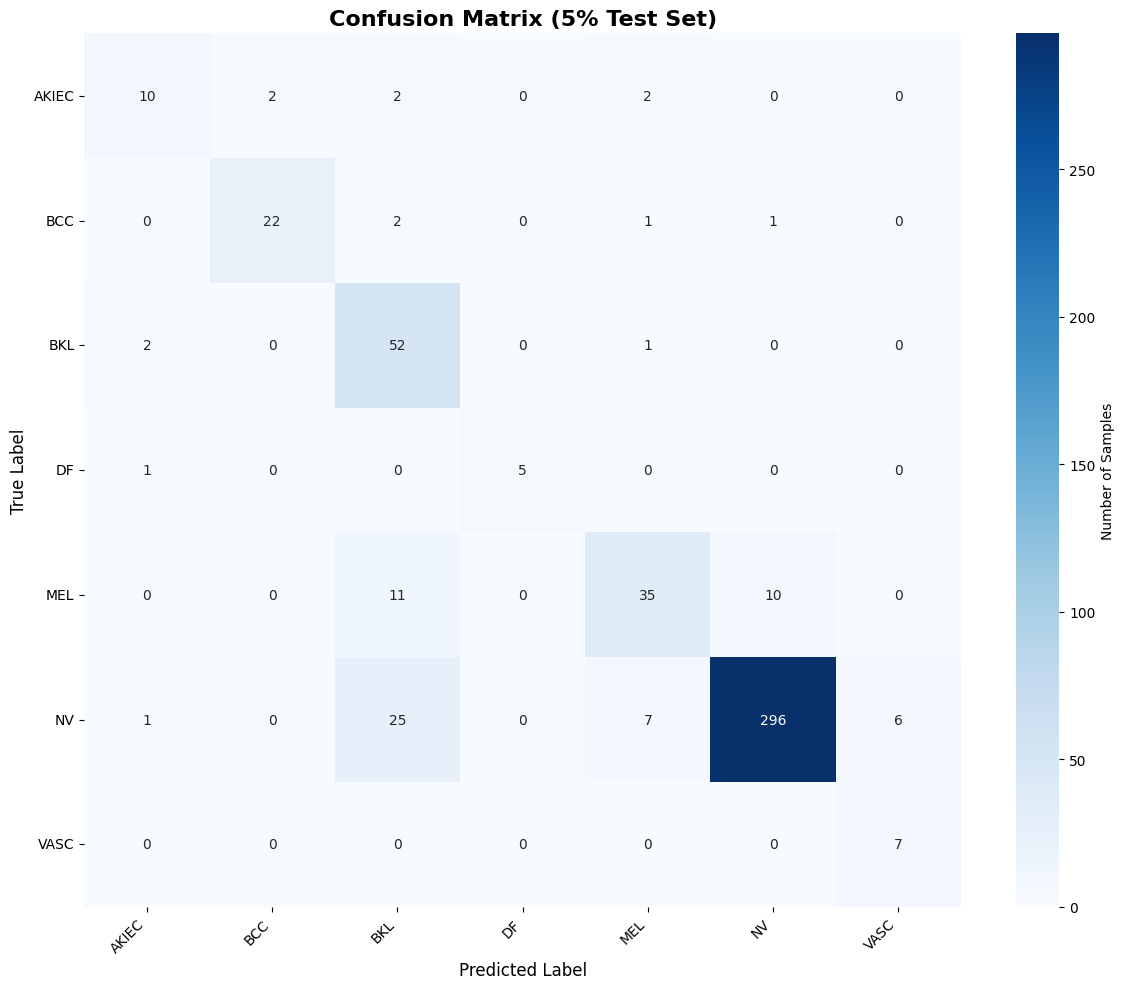

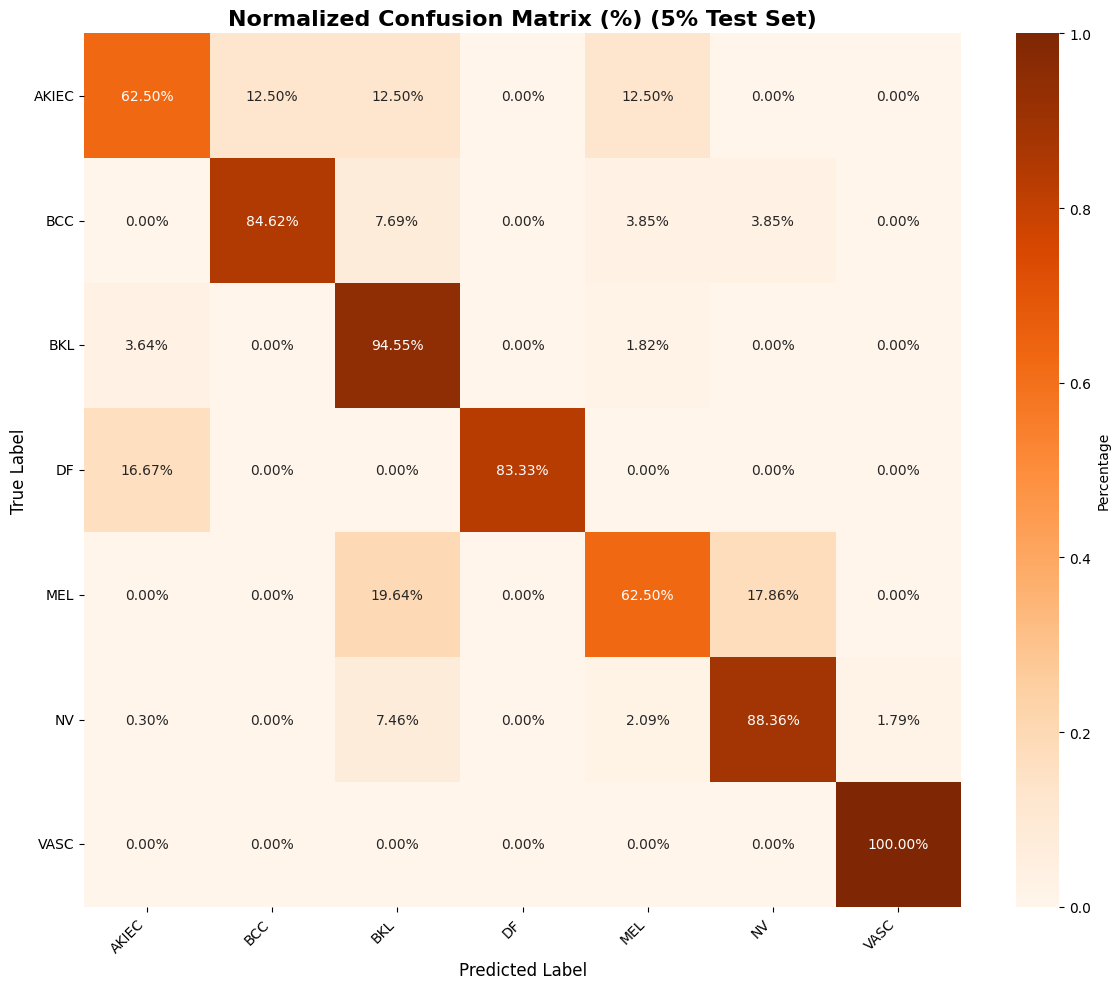

In [27]:
print("Confusion Matrix (5% Test Set)")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix (5% Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (%) (5% Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Final Summary

In [ ]:
# Get best epoch
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]

print(f"\nBest Model Performance based on Maximum Accuracy:")
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best validation loss: {best_val_loss:.4f}")

print(f"\nFinal Test Set Performance:")
print(f"Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Final test loss: {test_loss:.4f}")

print(f"\nTraining Statistics:")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Total epochs completed: {len(history.history['loss'])}")

print(f"\nFiles Saved:")
print(f"Best model saved as: 'best_resnet50_model.keras'")
print(f"Final model saved as: 'final_resnet50_model.keras'")

# Reset generators for future use
train_image_gen.reset()
val_image_gen.reset() # Added reset for the validation generator
final_test_image_gen.reset()

print(f"\nGenerators have been reset for future use")
print(f"Training samples: {train_image_gen.samples}")
print(f"Validation samples: {val_image_gen.samples}") # Correctly references the 15% validation set
print(f"Test samples: {final_test_image_gen.samples}") # Explicitly reports the 5% test set


Best Model Performance based on Maximum Accuracy:
Best epoch: 20
Best validation accuracy: 0.8490 (84.90%)
Best validation loss: 0.9067

Final Test Set Performance:
Final test accuracy: 0.8523 (85.23%)
Final test loss: 0.8102

Training Statistics:
Training time: 66.95 minutes
Total epochs completed: 20

Files Saved:
Best model saved as: 'best_resnet50_model.keras'
Final model saved as: 'final_resnet50_model.keras'

Generators have been reset for future use
Training samples: 12211
Validation samples: 1503
Test samples: 501


Live Demonstration

Upload image: mel.jpg
Original Image shape: (800, 800, 3)


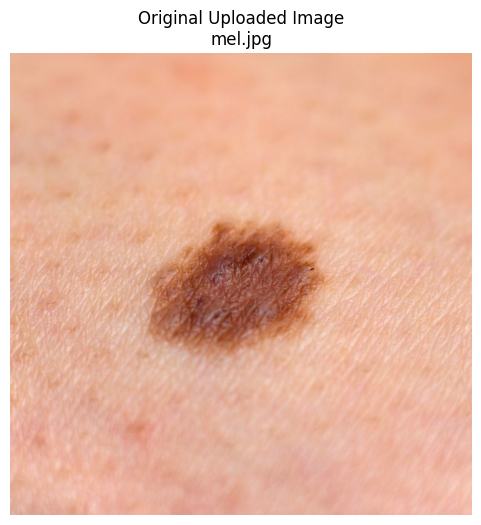

Load the best model
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


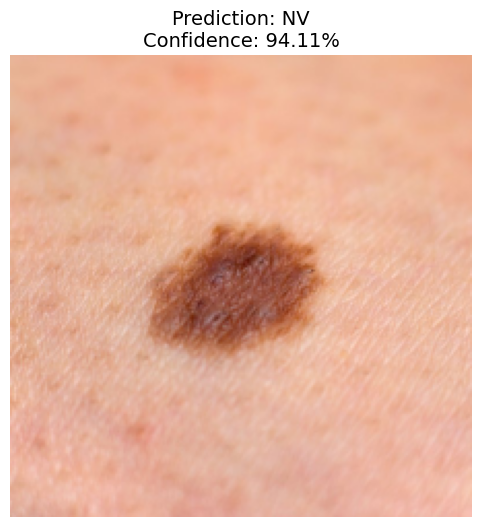

Confidence Scores:
AKIEC: 0.01%
BCC: 0.00%
BKL: 0.06%
DF: 0.00%
MEL: 5.82%
NV: 94.11%
VASC: 0.01%


In [ ]:
# Load the model
from tensorflow.keras.models import load_model

# Sample image name
image = 'mel.jpg'

# Get the labels or use the existing ones
try:
    class_labels = list(train_image_gen.class_indices.keys())
except:
    class_labels = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Load the image
print(f"Upload image: {image}")
img = cv2.imread(image)

if img is None:
    print(f"Error: Could not load '{image}'")
else:
    print(f"Original Image shape: {img.shape}")

    # Convert BGR (OpenCV default) to RGB for Matplotlib display
    img_rgb_orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb_orig)
    plt.title(f"Original Uploaded Image\n{image}", fontsize=12)
    plt.axis('off')
    plt.show()

    # Apply custom crop/resize function preprocessing
    img_processed = center_crop_and_resize(img, target_size=224)

    # Convert BGR (OpenCV standard) to RGB (model expects RGB)
    img_rgb = cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB)

    # Prepare for model for dimension (1, 224, 224, 3)
    img_batch = np.expand_dims(img_rgb, axis=0)

    # Apply ResNet50 specific preprocessing
    img_preprocessed = base_preprocess(img_batch.copy())

    # Load the best saved version of the model for maximum accuracy
    print("Load the best model")
    tl_model = load_model('best_resnet50_model.keras')

    # Prediction
    predictions = tl_model.predict(img_preprocessed)
    score = predictions[0]

    predicted_index = np.argmax(score)
    predicted_label = class_labels[predicted_index]
    confidence = np.max(score) * 100

    # Display Results
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=14)
    plt.axis('off')
    plt.show()

    # Print all class probabilities
    print("Confidence Scores:")
    for i, label in enumerate(class_labels):
        print(f"{label}: {score[i]*100:.2f}%")

Optionally Save the Best Model for Future Use

In [ ]:
shutil.copy('best_resnet50_model.keras', '/content/drive/MyDrive/best_resnet50_model.keras')
print("Model saved to Google Drive")

Model saved to Google Drive
